In [1]:
from dolfin import *
from mshr import *
from rbnics.backends.dolfin.wrapping import counterclockwise
from rbnics.shape_parametrization.utils.symbolic import VerticesMappingIO

In [2]:
# Define domain
outer_rectangle = Rectangle(Point(-2., -2.), Point(2., 2.))
inner_rectangle = Rectangle(Point(-1., -1.), Point(1., 1.))
domain = outer_rectangle - inner_rectangle

In [3]:
# Define vertices mappings of affine shape parametrization. These will be used
# to partition the mesh in subdomains.
vertices_mappings = [
    {
        ("-1", "-1"): ("-mu[0]", "-mu[1]"),
        ("-2", "-2"): ("-2", "-2"),
        ("1", "-1"): ("mu[0]", "-mu[1]")
    },  # subdomain 1
    {
        ("1", "-1"): ("mu[0]", "-mu[1]"),
        ("-2", "-2"): ("-2", "-2"),
        ("2", "-2"): ("2", "-2")
    },  # subdomain 2
    {
        ("-1", "-1"): ("-mu[0]", "-mu[1]"),
        ("-1", "1"): ("-mu[0]", "mu[1]"),
        ("-2", "-2"): ("-2", "-2")
    },  # subdomain 3
    {
        ("-1", "1"): ("-mu[0]", "mu[1]"),
        ("-2", "2"): ("-2", "2"),
        ("-2", "-2"): ("-2", "-2")
    },  # subdomain 4
    {
        ("1", "-1"): ("mu[0]", "-mu[1]"),
        ("2", "-2"): ("2", "-2"),
        ("1", "1"): ("mu[0]", "mu[1]")
    },  # subdomain 5
    {
        ("2", "2"): ("2", "2"),
        ("1", "1"): ("mu[0]", "mu[1]"),
        ("2", "-2"): ("2", "-2")
    },  # subdomain 6
    {
        ("-1", "1"): ("-mu[0]", "mu[1]"),
        ("1", "1"): ("mu[0]", "mu[1]"),
        ("-2", "2"): ("-2", "2")
    },  # subdomain 7
    {
        ("2", "2"): ("2", "2"),
        ("-2", "2"): ("-2", "2"),
        ("1", "1"): ("mu[0]", "mu[1]")
    }  # subdomain 8
]

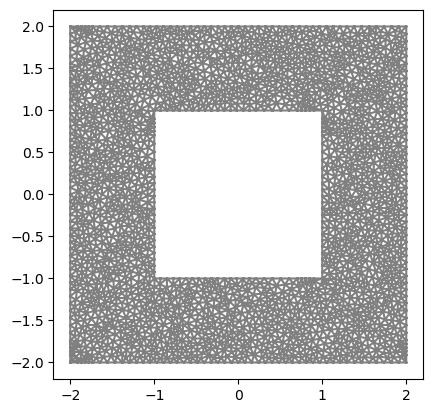

In [4]:
# Create mesh
for i, vertices_mapping in enumerate(vertices_mappings):
    subdomain_i = Polygon([Point(*[float(coord) for coord in vertex])
                           for vertex in counterclockwise(vertices_mapping.keys())])
    domain.set_subdomain(i + 1, subdomain_i)
mesh = generate_mesh(domain, 46)
plot(mesh)

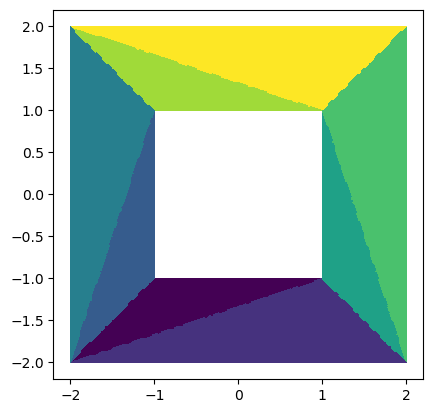

In [5]:
# Create subdomains
subdomains = MeshFunction("size_t", mesh, 2, mesh.domains())
plot(subdomains)

In [6]:
# Create boundaries
class LeftInner(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and abs(x[0] + 1.) < DOLFIN_EPS


class RightInner(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and abs(x[0] - 1.) < DOLFIN_EPS


class BottomInner(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and abs(x[1] + 1.) < DOLFIN_EPS


class TopInner(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and abs(x[1] - 1.) < DOLFIN_EPS


class LeftOuter(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and abs(x[0] + 2.) < DOLFIN_EPS


class RightOuter(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and abs(x[0] - 2.) < DOLFIN_EPS


class BottomOuter(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and abs(x[1] + 2.) < DOLFIN_EPS


class TopOuter(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and abs(x[1] - 2.) < DOLFIN_EPS


boundaries = MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
boundaries.set_all(0)
bottomInner = BottomInner()
bottomInner.mark(boundaries, 1)
leftInner = LeftInner()
leftInner.mark(boundaries, 2)
topInner = TopInner()
topInner.mark(boundaries, 3)
rightInner = RightInner()
rightInner.mark(boundaries, 4)
bottomOuter = BottomOuter()
bottomOuter.mark(boundaries, 5)
leftOuter = LeftOuter()
leftOuter.mark(boundaries, 6)
topOuter = TopOuter()
topOuter.mark(boundaries, 7)
rightOuter = RightOuter()
rightOuter.mark(boundaries, 8)

In [7]:
# Save
VerticesMappingIO.save_file(vertices_mappings, ".", "hole_vertices_mapping.vmp")
File("hole.xml") << mesh
File("hole_physical_region.xml") << subdomains
File("hole_facet_region.xml") << boundaries
XDMFFile("hole.xdmf").write(mesh)
XDMFFile("hole_physical_region.xdmf").write(subdomains)
XDMFFile("hole_facet_region.xdmf").write(boundaries)